# Машинное обучение, РЭШ

## [Практическое задание 3. Градиентный спуск своими руками](https://www.youtube.com/watch?v=dQw4w9WgXcQ)

### Общая информация
Дата выдачи: 17.11.2022

Дедлайн: 23:59MSK 24.11.2022

### О задании

В данном задании необходимо реализовать обучение линейной регрессии с помощью различных вариантов градиентного спуска.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.


### Формат сдачи
Задания загружаются на my.nes. Присылать необходимо ноутбук с выполненным заданием. 

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: ...

## Реализация градиентного спуска

Реализуйте линейную регрессию с функцией потерь MSE, обучаемую с помощью:

** Задание 1 (1 балл)** Градиентного спуска;

** Задание 2.1 (2 балла)** Стохастического градиентного спуска + Batch SGD;

** Задание 2.2 (2 балла)** SGD Momentum;

** Бонусное задание (2 балл)** Adagrad, RMSProp, Adam;

Во всех пунктах необходимо соблюдать следующие условия:

* Все вычисления должны быть векторизованы;
* Циклы средствами python допускается использовать только для итераций градиентного спуска;
* В качестве критерия останова необходимо использовать (одновременно):

    * проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$, задаваемого параметром `tolerance`);
    * достижение максимального числа итераций (например, 10000, задаваемого параметром `max_iter`).
* Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут класса `loss_history` — в нём после вызова метода `fit` должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту);
* Инициализировать веса можно случайным образом или нулевым вектором. 


Ниже приведён шаблон класса, который должен содержать код реализации каждого из методов.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import numpy as np
from sklearn.base import BaseEstimator

class LinearReg(BaseEstimator):
    def __init__(self, gd_type='batch', 
                 tolerance=1e-4, max_iter=1000, eta=1e-2, batch_size = 256):
        """
        gd_type: 'full' 'batch' (batch with batch_size 1 is considered as stochastic)
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        eta: learning rate
        alpha: momentum coefficient
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration
        self.batch_size = batch_size
    
    
    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        self.loss_history = []

        ones = np.ones(X.shape[0])[:, None] # create the bias vector
        X = np.hstack((ones, X.copy())) # add the bias vector
        y = y.copy()
        
        self.w = np.zeros(X.shape[1]) # initialize weights with the size of features in X
        
        n_iter = 0 # initialize iterations
        norm = self.tolerance + 1 # initialize distance
        while (n_iter < self.max_iter) & (norm >= self.tolerance):
            X_batch, y_batch = self.gen_batch(X, y) # generate a batch
            self.loss_history.append(self.calc_loss(X_batch, y_batch)) # calculate and append loss for this step
            w_prev = self.w.copy()
            self.make_step(X_batch, y_batch) # make a step
            dif = self.w - w_prev
            norm = np.sqrt(np.dot(dif, dif))

            n_iter += 1
        return self
    

    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        
        ones = np.ones(X.shape[0])[:, None] # create the bias vector
        X = np.hstack((ones, X.copy())) # add the bias vector

        preds = X @ self.w
        return preds
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """

        return 2 * np.dot(X.T, (np.dot(X, self.w) - y)) / y.shape[0]
    
    def gen_batch(self, X, y):
        if self.gd_type == 'full':
            return X, y
        elif self.gd_type == 'stochastic':
            ind = np.random.choice(X.shape[0], 1)
            return X[ind], y[ind]
        elif self.gd_type == 'batch':
            ind = list(np.random.choice(len(X), self.batch_size, replace=False))
            return X[ind], y[ind]
    
    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d) 
        y: np.array of shape (ell)
        ---
        output: float 
        """ 
        loss = float(0)
        loss = np.dot((y - np.dot(X, self.w)).T, (y - np.dot(X, self.w))) / y.shape[0]
        return loss
    
    def make_step(self, X, y):
        self.w -= self.eta * self.calc_gradient(X, y)

### Для более продвинух методов градиентного спуска отнаследуемся от базового класса LinearReg, поменяв метод make_step, а также добавив дополнительные аргументы в конструкторе класса

In [3]:
class Momentum(LinearReg):
    def __init__(self, alpha=0.9, **kwargs):
        super().__init__(**kwargs)
        self.h = 0
        self.alpha = alpha

    def make_step(self, X, y):
        self.h = self.alpha * self.h + self.eta * self.calc_gradient(X, y)
        self.w -= self.h

In [4]:
class Adagrad(LinearReg):
    def __init__(self, epsilon=1e-8, **kwargs):
        super().__init__(**kwargs)
        self.G = 0
        self.epsilon = epsilon
    def make_step(self, X, y):
        self.G = self.G + (self.calc_gradient(X, y))**2
        self.w -= (self.eta / (np.sqrt(self.G) + self.epsilon)) * self.calc_gradient(X, y)

In [5]:
class RMSProp(Adagrad):
    def __init__(self, alpha=0.9, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha

    def make_step(self, X, y):
        self.G = self.alpha * self.G + (1 - self.alpha) * (self.calc_gradient(X, y))**2
        self.w -= (self.eta / (np.sqrt(self.G) + self.epsilon)) * self.calc_gradient(X, y)

In [6]:
class Adam(LinearReg):
    def __init__(self, epsilon = 1e-8, beta_1 = 0.9, beta_2 = 0.999, **kwargs):
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

        self.m = 0
        self.v = 0

        self.m_hat = 0
        self.v_hat = 0
        super().__init__(**kwargs)

    def make_step(self, X, y):
        self.m = self.beta_1 * self.m  + (1 - self.beta_1) * self.calc_gradient(X, y)
        self.v = self.beta_2 * self.v + (1 - self.beta_2) * (self.calc_gradient(X, y))**2

        self.m_hat = self.m / (1 - self.beta_1)
        self.v_hat = self.v / (1 - self.beta_2)

        self.w -= self.eta / (np.sqrt(self.v_hat) + self.epsilon) * self.m_hat
    

** Задание 3 (0 баллов)**. 
* Загрузите данные из домашнего задания 2 ([train.csv](https://www.kaggle.com/c/nyc-taxi-trip-duration/data));
* Разбейте выборку на обучающую и тестовую в отношении 7:3 с random_seed=0;
* Преобразуйте целевую переменную `trip_duration` как $\hat{y} = \log{(y + 1)}$.

### Here we need to select some reasonable number of features and parform basic preprocessing. Here I decided to take everything up to inclusion of jam_trip feature.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score


import matplotlib.pyplot as plt
import seaborn as sns


from haversine import haversine

sns.set_theme()

In [8]:
# import dataset
df = pd.read_csv('./train.csv')

# transform target variable
df.pickup_datetime = df.pickup_datetime.astype('datetime64')
df['log_trip_duration'] = np.log1p(df['trip_duration'])

# create time features 
df['pickup_date'] = df['pickup_datetime'].dt.date
df['hour'] = df.pickup_datetime.dt.hour
df['weekday'] = df.pickup_datetime.dt.weekday
df['month'] = df.pickup_datetime.dt.month
df['day'] = df.pickup_datetime.dt.dayofyear

# create target variable and feature matrix
X = df.drop(columns=['log_trip_duration'])
y = df['log_trip_duration']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)

# Use datetime format for pickup_date feature
X_train['pickup_date'] = X_train['pickup_date'].astype('datetime64')
X_test['pickup_date'] = X_test['pickup_date'].astype('datetime64')

# create features for two anomalies
X_train['an_1'] = (X_train['pickup_date'] >= '2016-01-23') & (X_train['pickup_date'] <= '2016-01-25')
X_test['an_1'] = (X_test['pickup_date'] >= '2016-01-23') & (X_test['pickup_date'] <= '2016-01-25')
X_test['an_2'] =  (X_test['pickup_date'] >= '2016-05-29') & (X_test['pickup_date'] <= '2016-05-31')
X_train['an_2'] =  (X_train['pickup_date'] >= '2016-05-29') & (X_train['pickup_date'] <= '2016-05-31')

# create log_haversine feature
X_train['pickup'] = list(zip(X_train['pickup_latitude'], X_train['pickup_longitude']))
X_train['dropoff'] = list(zip(X_train['dropoff_latitude'], X_train['dropoff_longitude']))

X_test['pickup'] = list(zip(X_test['pickup_latitude'], X_test['pickup_longitude']))
X_test['dropoff'] = list(zip(X_test['dropoff_latitude'], X_test['dropoff_longitude']))

X_train['haversine'] = X_train.apply(lambda x: haversine(x['pickup'], x['dropoff']), axis=1)
X_test['haversine'] = X_test.apply(lambda x: haversine(x['pickup'], x['dropoff']), axis=1)

X_train['log_haversine'] = np.log1p(X_train['haversine'])
X_test['log_haversine'] = np.log1p(X_test['haversine'])

# create jam_trip feature
X_train['jam_trip'] = ((7 < X_train['hour']) & (X_train['hour'] < 20)) & ((0 <= X_train['weekday']) & (X_train['weekday']<=4))
X_test['jam_trip'] = ((7 < X_test['hour']) & (X_test['hour'] < 20)) & ((0 <= X_test['weekday']) & (X_test['weekday']<=4))

# throw away the columns that we won't need
X_train = X_train[['month', 'day', 'hour', 'weekday', 'an_1', 'an_2', 'log_haversine', 'jam_trip']]
X_test = X_test[['month', 'day', 'hour', 'weekday', 'an_1', 'an_2', 'log_haversine', 'jam_trip']]

# define the set of numeric and categorical variables
numeric_features = ['month', 'day', 'log_haversine']
categorical_features = ['hour', 'weekday', 'an_1', 'an_2', 'jam_trip']

# permorm standard preprocessing
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

X_train = column_transformer.fit_transform(X_train).toarray()
X_test = column_transformer.fit_transform(X_test).toarray()

y_train = np.array(y_train)
y_test = np.array(y_test)

In [9]:
reg_full = LinearReg(gd_type='full')
reg_stoch = LinearReg(gd_type='stochastic')
reg_batch = LinearReg(gd_type='batch')

reg_full.fit(X_train, y_train)
reg_stoch.fit(X_train, y_train)
reg_batch.fit(X_train, y_train)

LinearReg()

Text(0, 0.5, 'Loss')

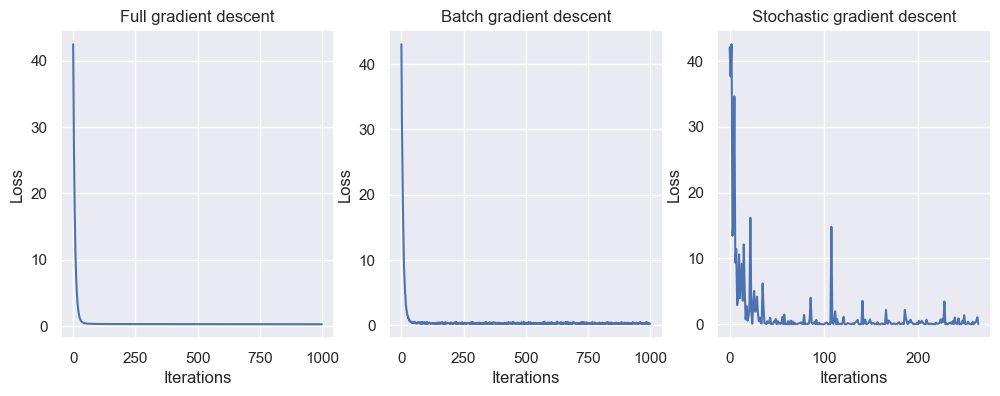

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

sns.lineplot(reg_full.loss_history, ax=ax[0])
ax[0].set_title('Full gradient descent')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Loss')

sns.lineplot(reg_batch.loss_history, ax=ax[1])
ax[1].set_title('Batch gradient descent')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Loss')


sns.lineplot(reg_stoch.loss_history, ax=ax[2])
ax[2].set_title('Stochastic gradient descent')
ax[2].set_xlabel('Iterations')
ax[2].set_ylabel('Loss')

** Задание 4 (3 балла)**. Обучите и провалидируйте модели на данных из предыдущего пункта, сравните качество между методами по метрикам MSE и $R^2$. Исследуйте влияние параметров `max_iter` и `eta` на процесс оптимизации. Согласуется ли оно с вашими ожиданиями?

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

Обучим все модели из прошлого пункта и посмотрим на финальные значения MSE и $R^2$. Здеась я ставлю 500 итераций и повышаю learning rate, чтобы модели быстрее сходились. Это не очень хорошая практика, потому что мы можем перескакивать минимум функции потерь при большем learning rate, но здесь это не кртичино. Зато считать будет быстрее. К тому же у AdaGrad есть проблемы со сходимостью на базовых параметрах.

In [12]:
# create the models

reg_full = LinearReg(gd_type='full', eta=0.05,  max_iter=500)
reg_batch = LinearReg(gd_type='batch', batch_size=128, eta=0.05,  max_iter=500)
reg_stoch = LinearReg(gd_type='stochastic', eta=0.05,  max_iter=500)
reg_moment = Momentum(eta=0.05,  max_iter=500)
reg_adag = Adagrad(eta=0.05,  max_iter=500)
reg_rms = RMSProp(eta=0.05,  max_iter=500)
reg_adam = Adam(eta=0.05,  max_iter=500)

In [13]:
# fit the models

reg_full.fit(X_train, y_train)
reg_batch.fit(X_train, y_train)
reg_stoch.fit(X_train, y_train)
reg_moment.fit(X_train, y_train)
reg_adag.fit(X_train, y_train)
reg_rms.fit(X_train, y_train)
reg_adam.fit(X_train, y_train)

Adam()

In [14]:
# predict the values for test
reg_full_pred = reg_full.predict(X_test)
reg_batch_pred = reg_batch.predict(X_test)
reg_stoch_pred = reg_stoch.predict(X_test)
reg_moment_pred = reg_moment.predict(X_test)
reg_adag_pred = reg_adag.predict(X_test)
reg_rms_pred = reg_rms.predict(X_test)
reg_adam_pred = reg_adam.predict(X_test)

In [15]:
# coumpute r_2 and MSE for all the methods

mse = {}
r2 = {}

methods = ['Full gradient', 'Batch gradient', 'Stochastic gradient', 'Momentum', 'Adagrad', 'RMSProp', 'Adam']
fits = [reg_full_pred, reg_batch_pred, reg_stoch_pred, reg_moment_pred, reg_adag_pred, reg_rms_pred, reg_adam_pred]

for i in range(len(methods)):
    mse[methods[i]] = mean_squared_error(y_test, fits[i])
    r2[methods[i]] = r2_score(y_test, fits[i])

Let us plot $R^2$

In [16]:
r2

{'Full gradient': 0.5844002615158506,
 'Batch gradient': 0.58306418822478,
 'Stochastic gradient': 0.13859823738329835,
 'Momentum': 0.6029939805241291,
 'Adagrad': 0.5812624871956296,
 'RMSProp': 0.42953077723589705,
 'Adam': 0.6066568971395285}

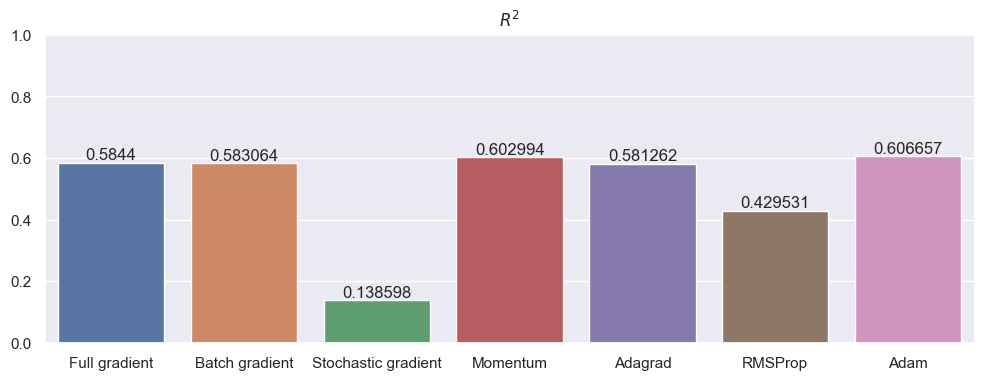

In [17]:
fig, ax = plt.subplots(figsize=(12,4))

ax = sns.barplot(x=list(r2.keys()), y=list(r2.values()))
ax.set_ylim([0, 1])
ax.set_title('$R^2$')

for i in ax.containers:
    ax.bar_label(i,)

The best $R^2$ is for Adam, the worst is for Stochastic gradient, which is predictable

Now, plot, MSE

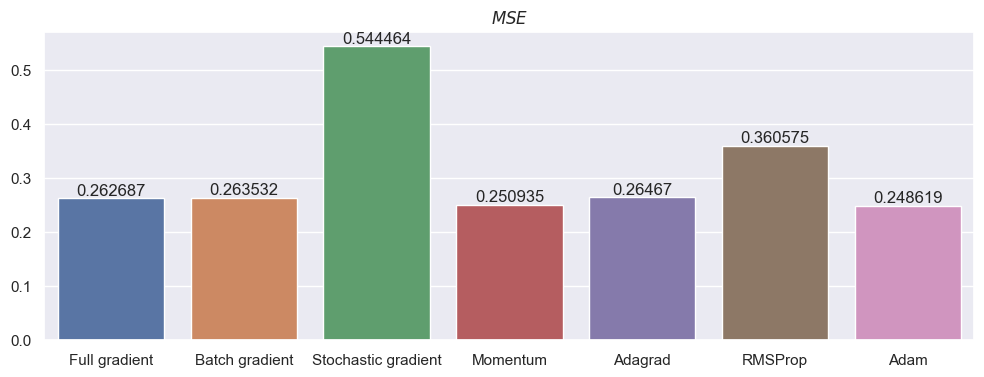

In [18]:
fig, ax = plt.subplots(figsize=(12,4))

ax = sns.barplot(x=list(mse.keys()), y=list(mse.values()))
ax.set_title('$MSE$')

for i in ax.containers:
    ax.bar_label(i,)

Again the best is Adam and the worst is Stochastic gradient

### Now, let us test Adam as the best performer with different values of eta and iter parameter

In [19]:
range_eta = np.logspace(-3, -1, 5)
range_iter = np.floor(np.linspace(100, 3000, 5))

Different etas

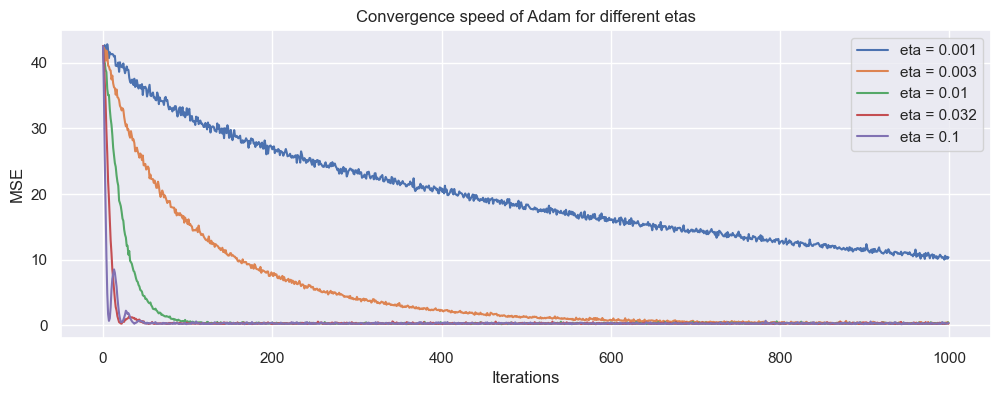

In [20]:
fig, ax = plt.subplots(figsize=(12, 4))

for eta in range_eta:
    reg = Adam(eta=eta)
    reg.fit(X_train, y_train)
    ax.plot(reg.loss_history, label=f'eta = {round(eta,3)}')

ax.set_title('Convergence speed of Adam for different etas')
ax.set_xlabel('Iterations')
ax.set_ylabel('MSE')
ax.legend();


As we can see with higher learning rate the speed of convergence is faster which is quite an expected behaviour

Now, do the same thing but for different values of iter parameter

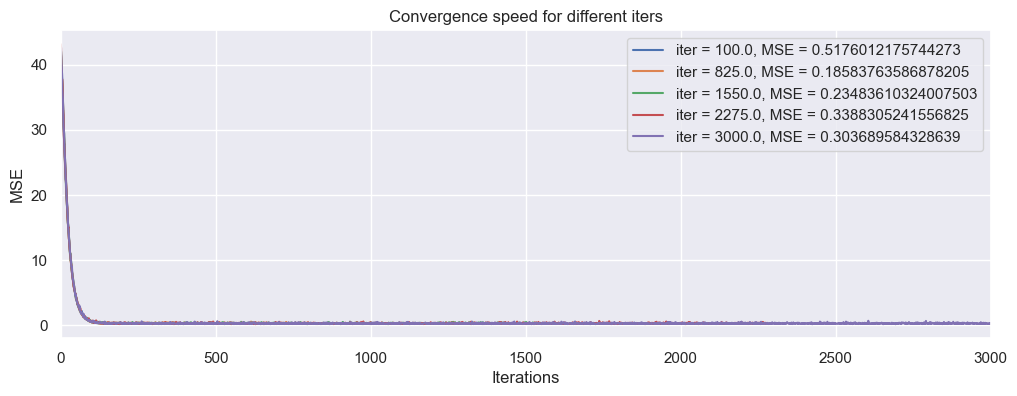

In [21]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.set_xlim([0, 3000])

for iter in range_iter:
    reg = Adam(max_iter=iter)
    reg.fit(X_train, y_train)
    ax.plot(reg.loss_history, label=f'iter = {iter}, MSE = {reg.loss_history[-1]}')

ax.set_title('Convergence speed for different iters')
ax.set_xlabel('Iterations')
ax.set_ylabel('MSE')
ax.legend();

Как видно, скорость сходимости почти одинаковая. Однако, чем дольше мы обучаемся, тем меньше у нас финальный лосс

** Задание 5 (6 балла)**. Постройте графики (на одной и той же картинке) зависимости величины функции потерь от номера итерации для всех реализованных видов стохастического градиентного спусков. Сделайте выводы о скорости сходимости различных модификаций градиентного спуска.

Не забывайте о том, что должны получиться *красивые* графики!

Мы уже делали фит для разных методов в предыдущем пункте. Осталось построить графики loss_history. Делаю на двух графиках, так как на одном все превращается в кашу по очевидным причинам.

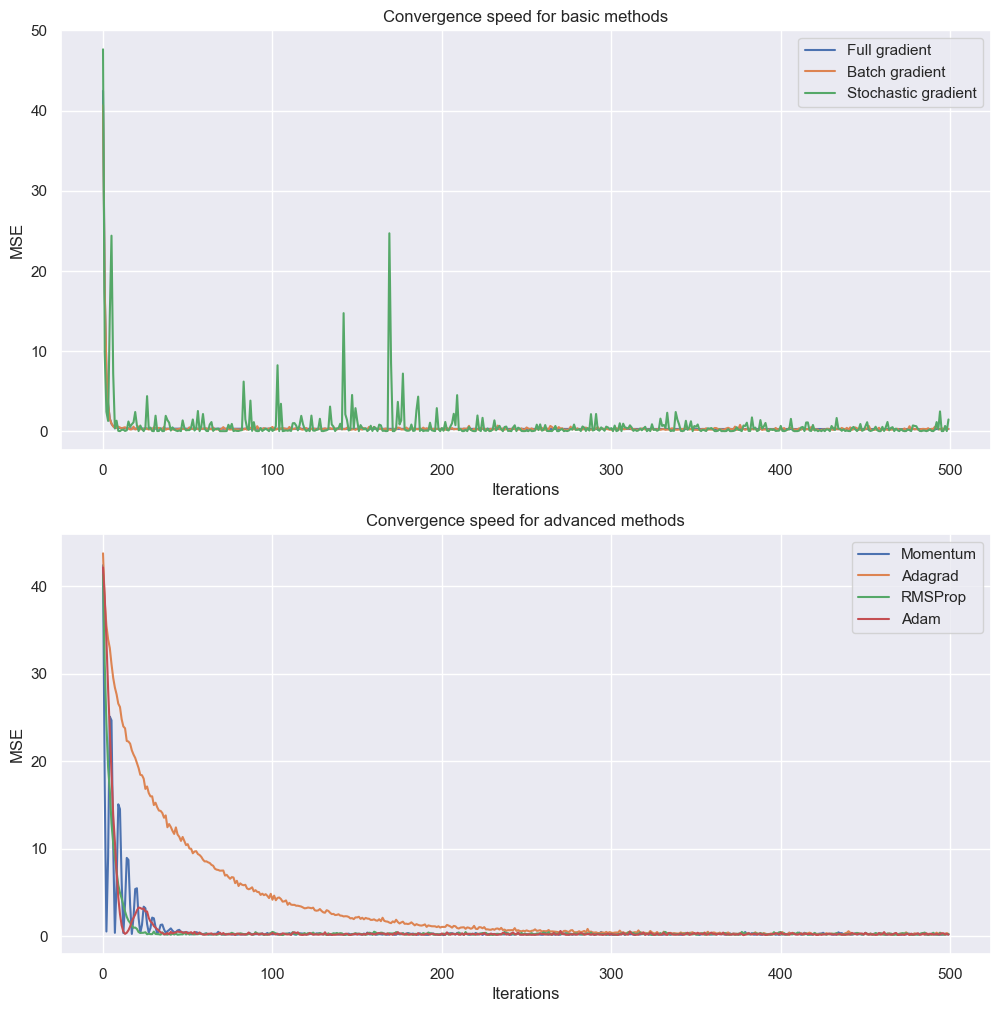

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(12,12))

ax[0].plot(reg_full.loss_history, label = 'Full gradient')
ax[0].plot(reg_batch.loss_history, label = 'Batch gradient')
ax[0].plot(reg_stoch.loss_history, label = 'Stochastic gradient')
ax[1].plot(reg_moment.loss_history, label = 'Momentum')
ax[1].plot(reg_adag.loss_history, label = 'Adagrad')
ax[1].plot(reg_rms.loss_history, label = 'RMSProp')
ax[1].plot(reg_adam.loss_history, label = 'Adam')

ax[0].set_title('Convergence speed for basic methods')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('MSE')
ax[0].legend()

ax[1].set_title('Convergence speed for advanced methods')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('MSE')
ax[1].legend();

Из базовых методов лучше всего сходится Full gradient, но его не используют, так как зачастую хранить в памяти весь dataset слишком дорого. Поэтому лучше всего использовать batch gradient вместе с какой-то реализацией dataloader-ов. 

Из продвинутых методов медленнее всего сходится Adam, так как величина в знаменателе, на которую мы делим на каждой итерации имеет аккумулирующий эффект, из-за чего обновления на каждом шаге становится все меньше и меньше. Вот хорошая иллюстрация того, как застревает Adagrad: 

![Adagrad_url](https://camo.githubusercontent.com/cccdc200cc2a3052ad9562f6f58ebd429d634fb1190a84b20db931e8ad4ffb8f/68747470733a2f2f692e737461636b2e696d6775722e636f6d2f316f6274562e676966 "AdaGrad")


Лучше всего сходятся RMSProp и Adam

** Задание 6 (бонус) (0.01 балла)**.  Вставьте картинку с вашим любимым мемом в этот Jupyter Notebook

![Adagrad_url](https://miro.medium.com/max/1100/1*E4_pTJctmAofSRpZCZbv-g.jpeg "AdaGrad")